# Stock Price Prediction of Microsoft

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM,Dense,Dropout
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.dates as mdates
from sklearn import linear_model


# Reading data using parse date
As it is timeseries data so we have to read the data by parsing date means making data column as index.

In [2]:
df_final = pd.read_csv("MSFT.csv",na_values=['null'],index_col='Date',parse_dates=True,infer_datetime_format=True)

In [3]:
df_final.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,0.605903,0.616319,0.598090,0.616319,0.447268,53033600
1990-01-03,0.621528,0.626736,0.614583,0.619792,0.449788,113772800
1990-01-04,0.619792,0.638889,0.616319,0.638021,0.463017,125740800
1990-01-05,0.635417,0.638889,0.621528,0.622396,0.451678,69564800
1990-01-08,0.621528,0.631944,0.614583,0.631944,0.458607,58982400


In [4]:

df_final.shape

(7334, 6)

In [5]:
df_final.describe()

,Open,High,Low,Close,Adj Close,Volume
count,7334.000000,7334.000000,7334.000000,7334.000000,7334.000000,7.334000e+03
mean,28.578362,28.891892,28.261203,28.582426,24.008891,6.022760e+07
std,22.279033,22.476021,22.054379,22.275692,21.941225,3.400345e+07
min,0.591146,0.604167,0.583333,0.598090,0.434039,3.705600e+06
25%,12.457031,12.595703,12.261719,12.488281,9.062849,3.821840e+07
50%,26.980000,27.235000,26.730000,26.990000,20.431164,5.429885e+07
75%,34.716562,35.099998,34.250000,34.687500,26.993589,7.367888e+07
max,115.419998,116.180000,114.930000,115.610001,115.112709,7.645040e+08


In [6]:
df_final.isnull().values.any()

False

<AxesSubplot:xlabel='Date'>

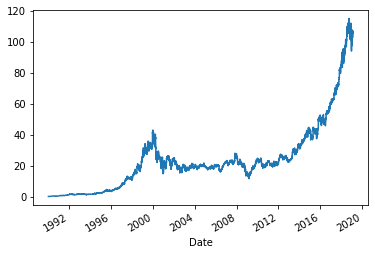

In [7]:
df_final['Adj Close'].plot()

# Correlation Analysis

In [8]:
X=df_final.drop(['Adj Close'],axis=1)
X=X.drop(['Close'],axis=1)

In [9]:
X.head()

,Open,High,Low,Volume
Date,,,,
1990-01-02,0.605903,0.616319,0.598090,53033600
1990-01-03,0.621528,0.626736,0.614583,113772800
1990-01-04,0.619792,0.638889,0.616319,125740800
1990-01-05,0.635417,0.638889,0.621528,69564800
1990-01-08,0.621528,0.631944,0.614583,58982400


<AxesSubplot:title={'center':'Correlation with Adj Close'}>

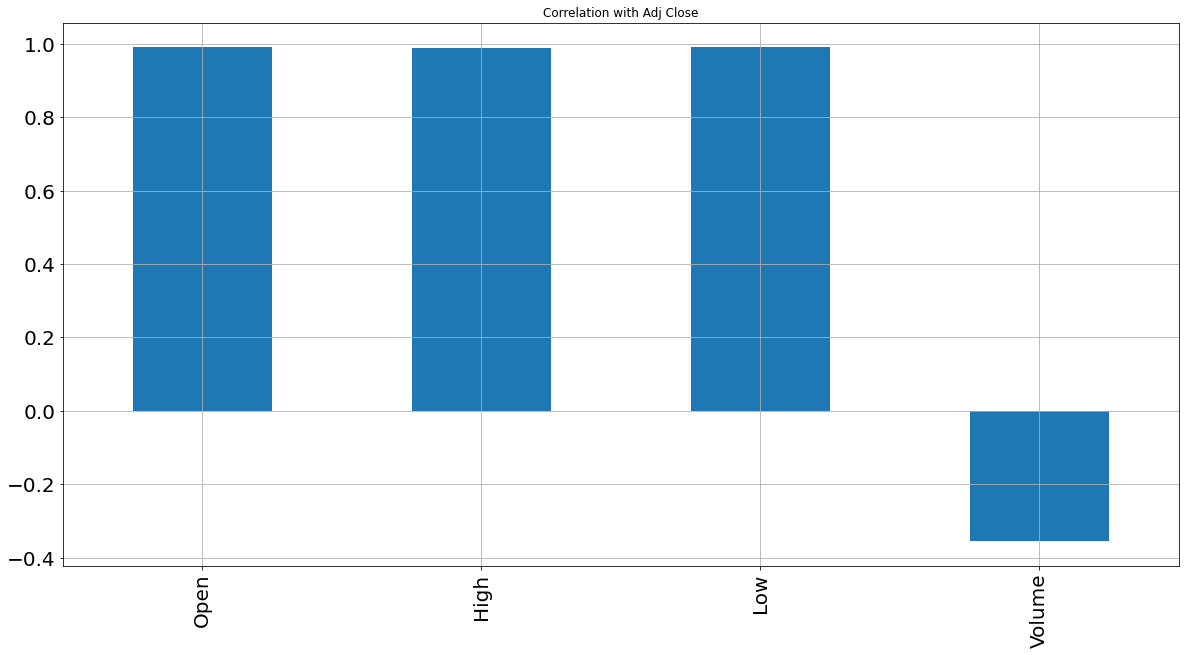

In [10]:
X.corrwith(df_final['Adj Close']).plot.bar(
        figsize = (20, 10), title = "Correlation with Adj Close", fontsize = 20,
        rot = 90, grid = True)

In [11]:
test = df_final
# Target column
target_adj_close = pd.DataFrame(test['Adj Close'])
display(test.head())

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1990-01-02,0.605903,0.616319,0.598090,0.616319,0.447268,53033600
1990-01-03,0.621528,0.626736,0.614583,0.619792,0.449788,113772800
1990-01-04,0.619792,0.638889,0.616319,0.638021,0.463017,125740800
1990-01-05,0.635417,0.638889,0.621528,0.622396,0.451678,69564800
1990-01-08,0.621528,0.631944,0.614583,0.631944,0.458607,58982400


In [12]:
target_adj_close.head()

,Adj Close
Date,
1990-01-02,0.447268
1990-01-03,0.449788
1990-01-04,0.463017
1990-01-05,0.451678
1990-01-08,0.458607


In [13]:
# selecting Feature Columns
feature_columns = ['Open', 'High', 'Low', 'Volume']

In [14]:
print(test.index)

DatetimeIndex(['1990-01-02', '1990-01-03', '1990-01-04', '1990-01-05',
               '1990-01-08', '1990-01-09', '1990-01-10', '1990-01-11',
               '1990-01-12', '1990-01-15',
               ...
               '2019-01-28', '2019-01-29', '2019-01-30', '2019-01-31',
               '2019-02-01', '2019-02-04', '2019-02-05', '2019-02-06',
               '2019-02-07', '2019-02-08'],
              dtype='datetime64[ns]', name='Date', length=7334, freq=None)


In [15]:
# shift rows from below and add nan row below 
target_adj_close.shift(-7)

,Adj Close
Date,
1990-01-02,0.435929
1990-01-03,0.434039
1990-01-04,0.434039
1990-01-05,0.447268
1990-01-08,0.440969
...,...
2019-02-04,NaN
2019-02-05,NaN
2019-02-06,NaN


In [16]:
target_adj_close.shape

(7334, 1)

In [18]:
# split 90 rows
target_adj_close[-90:-1]

,Adj Close
Date,
2018-10-01,115.112709
2018-10-02,114.654686
2018-10-03,114.674599
2018-10-04,112.304832
2018-10-05,111.647675
...,...
2019-02-01,102.779999
2019-02-04,105.739998
2019-02-05,107.220001


In [19]:
# total 7334 - 90 = remaining 7244 rows
target_adj_close[:-90]

,Adj Close
Date,
1990-01-02,0.447268
1990-01-03,0.449788
1990-01-04,0.463017
1990-01-05,0.451678
1990-01-08,0.458607
...,...
2018-09-24,114.176750
2018-09-25,113.957695
2018-09-26,113.489723


# Normalizing the data

In [17]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
feature_minmax_transform_data = scaler.fit_transform(test[feature_columns])
feature_minmax_transform = pd.DataFrame(columns=feature_columns, data=feature_minmax_transform_data, index=test.index)
feature_minmax_transform.head()

,Open,High,Low,Volume
Date,,,,
1990-01-02,0.000129,0.000105,0.000129,0.064837
1990-01-03,0.000265,0.000195,0.000273,0.144673
1990-01-04,0.000249,0.000300,0.000288,0.160404
1990-01-05,0.000386,0.000300,0.000334,0.086566
1990-01-08,0.000265,0.000240,0.000273,0.072656


In [21]:
display(feature_minmax_transform.head())
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target_adj_close.shape)

# Shift target array because we want to predict the n + 1 day value


target_adj_close = target_adj_close.shift(-1)
validation_y = target_adj_close[-90:-1]
target_adj_close = target_adj_close[:-90]

# Taking last 90 rows of data to be validation set
validation_X = feature_minmax_transform[-90:-1]
feature_minmax_transform = feature_minmax_transform[:-90]
display(validation_X.tail())
display(validation_y.tail())

print("\n -----After process------ \n")
print('Shape of features : ', feature_minmax_transform.shape)
print('Shape of target : ', target_adj_close.shape)
display(target_adj_close.tail())

,Open,High,Low,Volume
Date,,,,
1990-01-02,0.000129,0.000105,0.000129,0.064837
1990-01-03,0.000265,0.000195,0.000273,0.144673
1990-01-04,0.000249,0.000300,0.000288,0.160404
1990-01-05,0.000386,0.000300,0.000334,0.086566
1990-01-08,0.000265,0.000240,0.000273,0.072656


Shape of features :  (7334, 4)
Shape of target :  (7334, 1)


,Open,High,Low,Volume
Date,,,,
2019-02-01,0.898632,0.895480,0.889984,0.041838
2019-02-04,0.890707,0.910189,0.893657,0.036290
2019-02-05,0.918487,0.922908,0.921554,0.031046
2019-02-06,0.926673,0.920572,0.917794,0.022219
2019-02-07,0.910911,0.908372,0.906950,0.034247


,Adj Close
Date,
2019-02-01,105.739998
2019-02-04,107.220001
2019-02-05,106.029999
2019-02-06,105.269997
2019-02-07,105.669998



 -----After process------ 

Shape of features :  (7244, 4)
Shape of target :  (7244, 1)


,Adj Close
Date,
2018-09-24,113.957695
2018-09-25,113.489723
2018-09-26,113.917870
2018-09-27,113.878044
2018-09-28,115.112709


In [22]:
validation_X.shape

(89, 4)

In [19]:
target_adj_close.shape

(7334, 1)

In [23]:
feature_minmax_transform.shape

(7244, 4)

# Train test Split using Timeseriessplit

In [20]:
ts_split= TimeSeriesSplit(n_splits=10)
for train_index, test_index in ts_split.split(feature_minmax_transform):
        X_train, X_test = feature_minmax_transform[:len(train_index)], feature_minmax_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = target_adj_close[:len(train_index)].values.ravel(), target_adj_close[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [25]:
# Split the feature_minmax_transform 7244 to 6586 train 658 test
X_train.shape

(6586, 4)

In [22]:
X_test.shape

(666, 4)

In [27]:
y_train.shape

(6586,)

In [28]:
y_test.shape

(658,)

In [30]:
fut_inp = X_test[558:]

In [31]:
fut_inp.head()

,Open,High,Low,Volume
Date,,,,
2018-09-05,0.961595,0.958815,0.940269,0.038337
2018-09-06,0.937559,0.937790,0.935110,0.025988
2018-09-07,0.937385,0.935454,0.932661,0.024702
2018-09-10,0.942697,0.943414,0.942543,0.022374
2018-09-11,0.943220,0.960286,0.947178,0.027072


In [34]:
fut_inp[1:]

,Open,High,Low,Volume
Date,,,,
2018-09-06,0.937559,0.937790,0.935110,0.025988
2018-09-07,0.937385,0.935454,0.932661,0.024702
2018-09-10,0.942697,0.943414,0.942543,0.022374
2018-09-11,0.943220,0.960286,0.947178,0.027072
2018-09-12,0.965253,0.962535,0.961346,0.019960
...,...,...,...,...
2019-02-04,0.890707,0.910189,0.893657,0.036290
2019-02-05,0.918487,0.922908,0.921554,0.031046
2019-02-06,0.926673,0.920572,0.917794,0.022219


In [29]:
def validate_result(model, model_name):
    predicted = model.predict(validation_X)
    RSME_score = np.sqrt(mean_squared_error(validation_y, predicted))
    print('RMSE: ', RSME_score)
    
    R2_score = r2_score(validation_y, predicted)
    print('R2 score: ', R2_score)

    plt.plot(validation_y.index, predicted,'r', label='Predict')
    plt.plot(validation_y.index, validation_y,'b', label='Actual')
    plt.ylabel('Price')
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.title(model_name + ' Predict vs Actual')
    plt.legend(loc='upper right')
    plt.show()

# Benchmark Model

RMSE:  64.22105109555618
R2 score:  -304.3934023786509


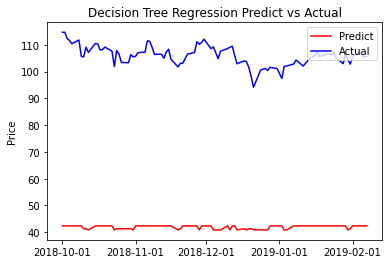

In [30]:
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(random_state=0)

benchmark_dt=dt.fit(X_train, y_train)

validate_result(benchmark_dt, 'Decision Tree Regression')

# Process the data for LSTM

In [31]:
X_train =np.array(X_train)
X_test =np.array(X_test)

X_tr_t = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_tst_t = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [32]:
X_train.shape

(6586, 4)

In [33]:
X_tr_t.shape

(6586, 1, 4)

In [34]:
X_test.shape

(658, 4)

In [35]:
X_tst_t.shape

(658, 1, 4)

# Model building : LSTM

In [36]:

from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model
from keras.layers import LSTM
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(1, X_train.shape[1]), activation='relu', return_sequences=False))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=10, verbose=1)
history_model_lstm = model_lstm.fit(X_tr_t, y_train, epochs=200, batch_size=8, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/200
824/824 [==============================] - 2s 795us/step - loss: 167.3892
Epoch 2/200
824/824 [==============================] - 1s 815us/step - loss: 30.5553
Epoch 3/200
824/824 [==============================] - 1s 910us/step - loss: 29.1063
Epoch 4/200
824/824 [==============================] - 1s 795us/step - loss: 19.1708
Epoch 5/200
824/824 [==============================] - 1s 769us/step - loss: 9.9946
Epoch 6/200
824/824 [==============================] - 1s 807us/step - loss: 4.3840
Epoch 7/200
824/824 [==============================] - 1s 871us/step - loss: 2.0700
Epoch 8/200
824/824 [==============================] - 1s 853us/step - loss: 1.4177
Epoch 9/200
824/824 [==============================] - 1s 750us/step - loss: 1.2234
Epoch 10/200
824/824 [==============================] - 1s 750us/step - loss: 1.1291
Epoch 11/200
824/824 [==============================] - 1s 750us/step - loss: 1.0706
Epoch 12/200
824/824 [==============================] - 1s 758us/step

# Evaluation of Model

In [37]:
y_pred_test_lstm = model_lstm.predict(X_tst_t)
y_train_pred_lstm = model_lstm.predict(X_tr_t)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
r2_train = r2_score(y_train, y_train_pred_lstm)

print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))
r2_test = r2_score(y_test, y_pred_test_lstm)


The R2 score on the Train set is:	0.879
The R2 score on the Test set is:	0.818


In [60]:
print(y_pred_test_lstm)

[[48.84068 ]
 [48.302296]
 [47.360455]
 [47.92247 ]
 [48.54639 ]
 [47.72674 ]
 [47.98087 ]
 [48.855656]
 [48.87334 ]
 [48.589928]
 [47.847095]
 [47.70438 ]
 [48.57771 ]
 [48.749214]
 [49.14063 ]
 [49.23541 ]
 [49.261898]
 [50.017635]
 [50.508106]
 [50.76871 ]
 [49.577484]
 [49.92756 ]
 [50.132336]
 [50.07784 ]
 [50.03243 ]
 [50.116867]
 [51.134113]
 [51.133896]
 [51.068836]
 [51.28537 ]
 [50.95447 ]
 [50.627377]
 [50.6825  ]
 [50.777935]
 [50.679028]
 [50.395267]
 [51.113552]
 [51.23628 ]
 [51.41708 ]
 [51.6583  ]
 [52.20931 ]
 [52.020145]
 [51.800724]
 [48.692013]
 [48.295956]
 [48.335026]
 [47.75652 ]
 [46.989655]
 [46.43561 ]
 [46.812523]
 [46.715054]
 [46.410793]
 [46.580254]
 [46.5961  ]
 [46.882454]
 [47.073963]
 [47.759487]
 [47.764324]
 [47.886993]
 [47.61675 ]
 [47.741554]
 [47.175816]
 [46.86619 ]
 [47.223896]
 [46.983532]
 [47.49672 ]
 [48.434307]
 [48.158062]
 [48.339954]
 [48.8506  ]
 [48.922207]
 [48.719105]
 [48.48345 ]
 [48.408436]
 [48.670635]
 [48.454998]
 [48.19991 ]

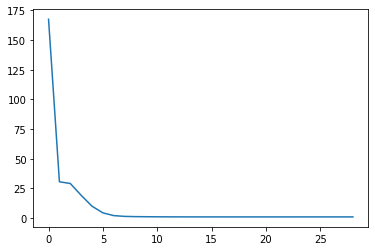

In [40]:
loss = history_model_lstm.history['loss']
plt.plot(loss)

## Predictions made by LSTM

In [41]:
score_lstm= model_lstm.evaluate(X_tst_t, y_test, batch_size=1)

658/658 [==============================] - 0s 424us/step - loss: 65.5904


In [42]:
print('LSTM: %f'%score_lstm)

LSTM: 65.590439


In [43]:
y_pred_test_LSTM = model_lstm.predict(X_tst_t)

# LSTM's Prediction Visual

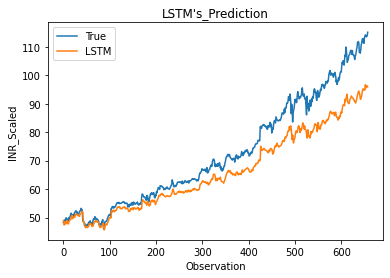

In [44]:
plt.plot(y_test, label='True')
plt.plot(y_pred_test_LSTM, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()


# Forecasting 7 Days Trend 

In [68]:
len(X_tst_t)

658

In [69]:
X_tst_t.shape

(658, 1, 4)

In [70]:
# Getting Last 100 Days records
fut_inp = X_tst_t[558:]

In [71]:
fut_inp.shape


(100, 1, 4)

In [76]:
fut_inp = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

In [77]:
fut_inp.shape

(658, 1, 4)

In [78]:
# Creating list of input data
fut_inp = fut_inp[0].tolist()

In [81]:
st_output=[]
n_steps=100
i=0
while(i<7):
    if(len(fut_inp)>100):
        for_inp = np.array(fut_inp[1:])
        for_inp = for_inp.reshape(1,-1)
        for_inp = for_inp.reshape((1, n_steps, 1))
        yhat = history_model_lstm.predict(for_inp, verbose=0)
        fut_inp.extend(yhat[0].tolist())
        fut_inp = fut_inp[1:]
        st_output.extend(yhat.tolist())
        i=i+1
    else:
        for_inp = for_inp.reshape((1, n_steps, 1))
        yhat = history_model_lstm.predict(for_inp, verbose=0)
        fut_inp.extend(yhat[0].tolist())
        
        st_output.extend(yhat.tolist())
        i=i+1
print(st_output)
        

ValueError: cannot reshape array of size 399 into shape (1,100,1)

# Converting Prediction data
In this step I have made the prediction of test data and will convert the dataframe to csv so that we can see the price difference between actual and predicted price.

In [47]:
col1 = pd.DataFrame(y_test, columns=['True'])

col2 = pd.DataFrame(y_pred_test_LSTM, columns=['LSTM_prediction'])

col3 = pd.DataFrame(history_model_lstm.history['loss'], columns=['Loss_LSTM'])
results = pd.concat([col1, col2, col3], axis=1)
results.to_excel('PredictionResults_LSTM_NonShift1.xlsx')

# Conclusion

It is impossible to  get a model that can 99% predict the price without any error, there are too many factors can affect the
stock prices. So, we cannot hope there is a perfect model, but the general trend of predicted price is in line with the actual data, so the trader could have an indicator to reference, and makes trading decision by himself.


Further, we can improve the model's accuracy by increasing the epochs, trying out different activation functions or even change the model's structure. As exact 